In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Part 1: logins

In [70]:
logins_df = pd.read_json('./logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [71]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


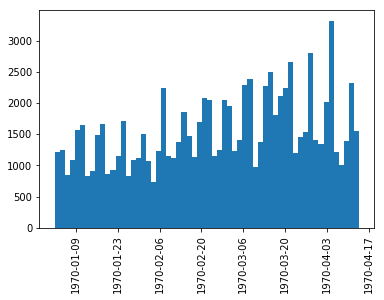

In [72]:
plt.hist(logins_df.login_time, bins=60)
plt.xticks(rotation=90)
plt.show()

In [73]:
logins_df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [74]:
logins_df.set_index('login_time', inplace=True)

In [75]:
logins_df['count'] = 1

In [76]:
logins_df.resample('15T', how='sum')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


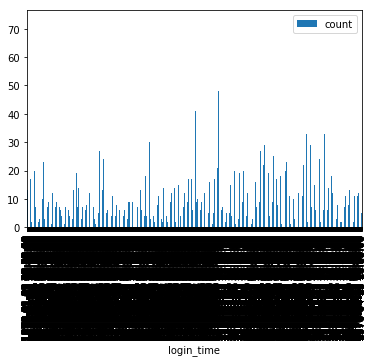

In [80]:
logins_df.groupby(pd.Grouper(freq='15Min')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Looking at each 15-minute batch is clearly impossible to interpret like this.

In [81]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
count    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


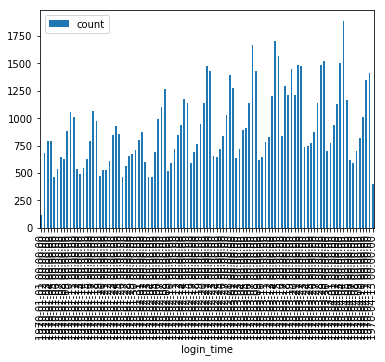

In [82]:
logins_df.groupby(pd.Grouper(freq='D')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Looking on a daily basis it is still difficult to make sense of the signals, but there seemed to be a spike every 7 days, with increasing signal each day before that. For some weeks this pattern deviated a little, but it was present for many. This suggests something about the service is either not useful equally on each day of the week, or there is a technical issue that occurs on a weekly basis that the service slowly recovers from in terms of interaction with consumers. It is difficult to tell from here, but January 1, 1970, was a Thursday (unless these are made-up dates that reflect a later period, or something). Looking at that first week and the following weeks - the weekends were the times of greatest login activity, with Fridays ramping up to it. This was a service that was most used on the weekends. This is intriguing, though, as 1970 was a very long time ago; what were people logging into in 1970? Computer-related logins I would expect to be more restricted to the government/military at that time. That sort of activity would be unlikely to be highest on the weekends. A business that has most of its activity when people are at home could also fit the pattern, though I do not know how many businesses were set up for a login-type structure at that time. The public would be making more use of home consumer devices perhaps during the weekends, and what was around at that time I would suspect related to television, radio, or telephone. Cable television also existed back then (for a long time at that point), and perhaps there was some message returned to the cable company when people turned on their devices or changed channels, but I doubt that. Ratings devices could also be a source of logins, however, I believe Nielsen did not begin using "people meters" for ratings until the 1980s, relying on diaries prior to that point.

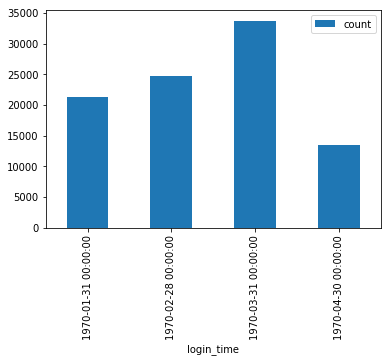

In [83]:
logins_df.groupby(pd.Grouper(freq='M')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Overall volume of logins picked up from the start of January through March. Then the month of April showed a precipitous drop, below that of January's login frequencies even. I will focus on this period for further analysis because a drop in consumer activity is significantly more pertinent to address than a steady rise in consumer activity is.

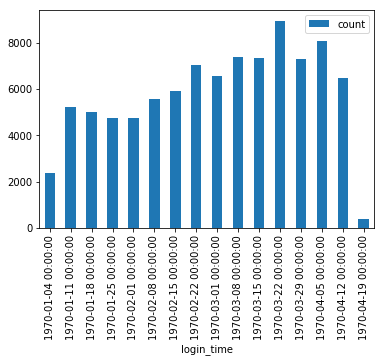

In [84]:
logins_df.groupby(pd.Grouper(freq='W')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Mid- to late-March had the highest login volume. The first week of April was similar to preceding weeks and showed more logins than the last week of March did. The second week of April showed a slight drop, still getting the bulk of the volume of weeks leading up to it, but back down on par with the last week of February (into March 1). This was enough of a drop that it should have drawn some concern. Then the third week of April showed a disastrous drop. Something happened, as the login frequency was suddenly extremely low. A number of unknowns could explain it, but I would suspect something along the lines of 1) a technical problem, 2) a change to terms of service or perhaps a new fee structure, or 3) a competitor service had suddenly drawn attention. The third I predict is the least likely explanation, because I would expect a shift to a competitor would be more gradual. 

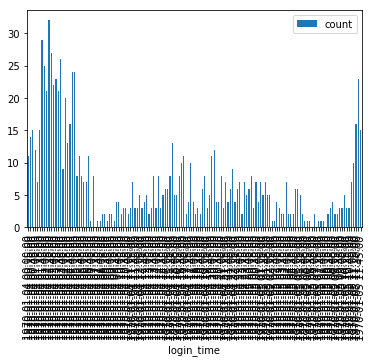

In [118]:
logins_df['1970-01-04 00:00:00':'1970-01-5 11:59:59'].groupby(pd.Grouper(freq='15Min')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Above is a view of the first day of logins from this dataset. I do not know what time zone these entries are based on, nor where the entirety of login attempts occurred, but this shows the logins were primarily around midnight or later, picking up slightly during the mid-day. 

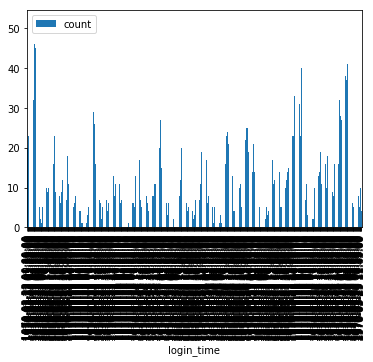

In [110]:
logins_df['1970-03-22 00:00:00':'1970-03-29 11:59:59'].groupby(pd.Grouper(freq='15Min')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

The week with the highest volume of logins (above) showed what looks like a roughly diurnal cycle. Now, as for an explanation of what happened in mid- to late-April, we will start by looking at the week from April 12 through April 19.

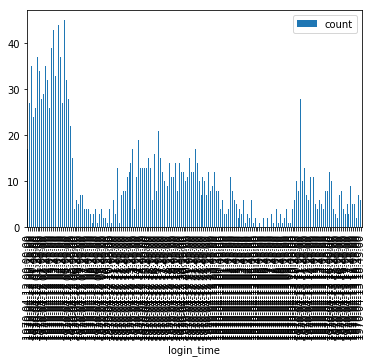

In [114]:
logins_df['1970-04-12 00:00:00':'1970-04-19 11:59:59'].groupby(pd.Grouper(freq='15Min')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

There was a particularly precipitous drop during that week, it is quite clear here. Early in that week, perhaps April 12 or 13, the drop in logins went down by about an order of magnitude very quickly. It rose again over the next day or two, but not to the earlier level. Perhaps something happened that made it difficult for most users to log back in, either technically or in terms of users' sense of reliability or usefulness of the service.

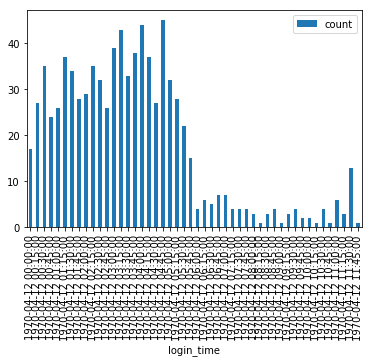

In [117]:
logins_df['1970-04-12 00:00:00':'1970-04-12 11:59:59'].groupby(pd.Grouper(freq='15Min')).count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

On April 12, in about the 5 am hour, the serious drop in login frequency occurred. From a high point at 5:00 am to a low point at 6:00 am (in 15-minute increments). This suggests a technical issue; even a change to terms of service would likely show up in a slower pattern. An alternative and very specific explanation could be that these logins reflect activities at a business that was most active at night at which workers got laid off in large numbers, with their final shift being that day. Again, I am not sure what "login" refers to in this case, though time clocks for punching in had existed well before then. That would again mean a business that had most activity on the weekends, and apparently very late at night. I think this explanation is less likely than a technical issue is, but it is a possibility to consider. Looking at historical information for that date, the thing that pops up is the sinking of a Soviet submarine, though it is a stretch to think the normal fluctuating patterns in these data would reflect anything related to that.

# Part 2: Gotham/Metropolis

A key measure of success in the Ultimate Gotham/Ultimate Metropolis challenge could be whether there is equivalent allocation of available drivers in both cities (i.e., driver quantities at the same ratio to passenger need or same average distances to passengers in need, reduced number of ride rejections by drivers due to bridge traversal, etc.), and another type of metric could be how much time each driver spends in either city during a period of time (day or night). Each metric could be valid. The question specifically relates to encouragement of drivers to be in both cities. In this vein, a third type of metric could be how much the average driver's daily earnings changes after tolls are removed for them. If I were a city manager I would include all metrics in my analysis, though the first type of metric would be the one serving the most constituents between the two cities. The obvious intent behind the experiment is to ensure passengers are able to get to either city at any time, and drivers are also interested in this goal as it limits their options less. 

If there must be one metric to choose that is specific to assessing the value of this experiment, I would first choose "frequency of ride rejections involving bridge traversal". This is not a long-term metric of ultimate success for the ride service in that region, but it is a metric that relates specifically to the experiment at hand. Another reason for this choice is that a concern I would have with the city managers' plan is that removing tolls, while certainly welcoming to drivers, may not be enough to alleviate the problem. If the bridge itself imparts a traffic bottleneck, for instance, then drivers may feel it is not worth an opportunity loss they may incur by not being able to pick up other fares in that time. Also, reimbursements are never as satisfying as upfront waivers are; if there is any administrative complexity in returning the toll fare to the driver, it likely is not a strong incentivizer for the driver to cross the bridge. The drive itself may be longer than drivers wish to take on a regular basis for other reasons, too. If there is no difference in ride rejections based on crossing the bridge, which would be the null hypothesis for this experiment, then the toll relief has no significant effect. 

Since this is an experiment, for cost purposes it should be treated as a pilot program. There should be a number of drivers sampled from both cities, at a level appropriate for giving statistical analyses the appropriate power (enough drivers for meaningful analyses, but not so many that small signals look significant). It is not clear if there is an imbalance in numbers between the two cities; in any case, the ratio of drivers based in each city should be similar to that of the total driver populations, and they should be randomly sampled. 

There are a number of analyses possible, but I would first establish a baseline rate of bridge-rejections on either side of the bridge, and this could be considered collectively or per-individual with both within-subjects and between-subjects tests, including also a sample population that does not receive toll reimbursements. Also, since we have two populations of drivers, and a binary target characteristic (yes or no for bridge-rejections), we could do before and after chi-squared tests of independence to see if there's any difference between the populations in their tendencies to reject bridge travel. Individual statistical analyses that could be performed include t-tests and bootstrap or permutation tests to test the null hypothesis of no effect versus the alternative hypothesis that reimbursing tolls significantly increases bridge crossings. Each of these tests should be performed. With the way I have structured the target variable (binary rather than continuous, such as, say, average or maximum distances traveled), the effects on this metric based on specific variables would be best examined with logistic regression. There are many variables that could be included in the analysis, but the following would be critical, in my opinion: location where driver is based, length of time of driver's shift(s)(average or total), distance per trip, distance per shift, total ride rejections by driver (including both bridge and non-bridge travel), times of day of trips, perhaps times of day of rejections (to hopefully incorporate traffic).

If the experiment is successful, then the hypothesis tests should all result in a show of an increase in rides across the bridge at a level that reflects statistical significance - could be p<0.05, though for implementation of a plan with potential cost consequences, a stronger show of significance should be considered. Speaking of cost, that is also a metric that should be included for each city, as in how much revenue is lost from the experimental population versus the control population (which may be little if all drivers are simply avoiding the toll bridge as it is). 

# Part 3: Ultimate 

## Data import, cleanup, and initial viewing

In [2]:
#data_df = pd.read_json('./ultimate_data_challenge.json', dtype=dict, orient='records', lines=True)
data = './ultimate_data_challenge.json'
with open(data) as file:
    dict_file = json.load(file)
data_df = pd.DataFrame.from_dict(dict_file, orient='columns')

In [3]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [6]:
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])
data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])

data_df['days'] = np.nan

data_df['days'] = data_df['last_trip_date'] - data_df['signup_date']

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days                      50000 non-null timedelta64[ns]
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2), timedelta64[ns](1)
memory usage: 4.6+ MB


In [8]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47 days


In [9]:
# say "into month 6" = 5/12 * 365 + 1 day = 153 days. This of course may not be accurate depending on months.
# Feb is in each since the period is signups in January, but the end month for each would vary by one day.
# target variable for prediction will be for y in train_test (days >= 153).values. 


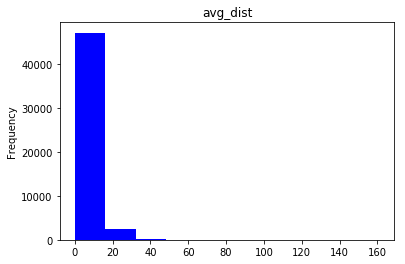

In [10]:
data_df['avg_dist'].plot(kind='hist', color='blue')
plt.title('avg_dist')
plt.show()

Most trips fell within 20 miles.

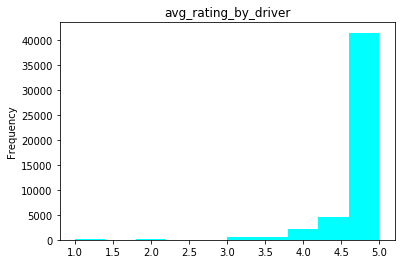

In [11]:
data_df['avg_rating_by_driver'].plot(kind='hist', color='aqua')
plt.title('avg_rating_by_driver')
plt.show()

Drivers tended to give high, if not maximum, ratings to riders.

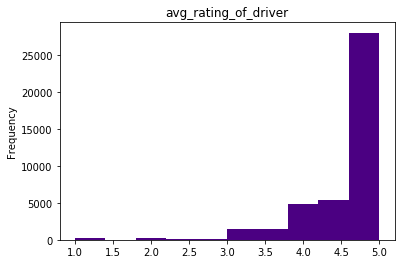

In [12]:
data_df['avg_rating_of_driver'].plot(kind='hist', color='indigo')
plt.title('avg_rating_of_driver')
plt.show()

Riders tended to be generous with ratings of drivers, but there was a relatively higher amount of sub-maximum ratings here than with ratings by drivers.

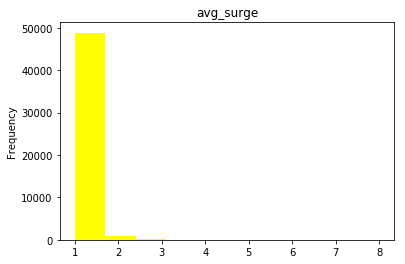

In [13]:
data_df['avg_surge'].plot(kind='hist', color='yellow')
plt.title('avg_surge')
plt.show()

The surge multiplier tended to be 1-2.

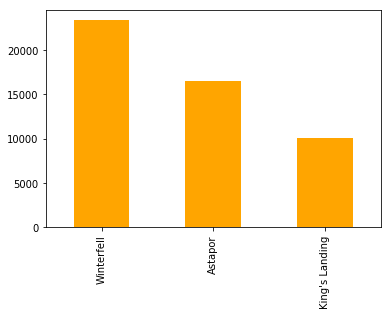

In [14]:
data_df['city'].value_counts().plot(kind='bar', color='orange')
plt.show()

Winterfell ranked first for number of users, though all three had a substantial showing.

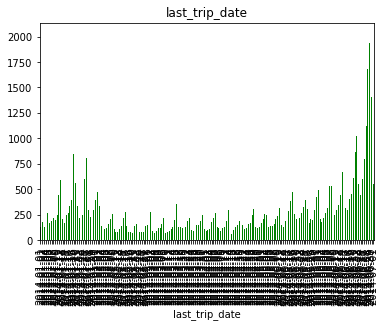

In [15]:
data_df.groupby(data_df['last_trip_date'].dt.date).count().plot(kind="bar", color='green', legend=None)
plt.title('last_trip_date')
plt.show()

The last trip date was later, close to the end of the measurement period, for a large amount of users. However, the spikes near the end mask the accumulation of earlier dates among riders throughout the period. 

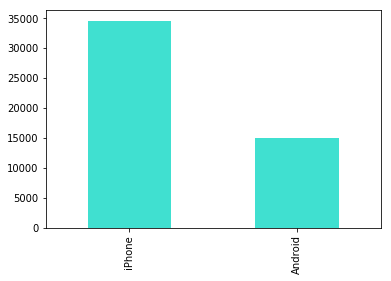

In [16]:
data_df['phone'].value_counts().plot(kind='bar', color='turquoise')
plt.show()

Slightly more than twice as many users used iPhones than Android phones.

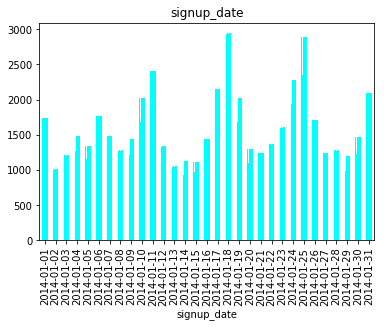

In [17]:
data_df.groupby(data_df['signup_date'].dt.date).count().plot(kind="bar", color='cyan', legend=None)
plt.title('signup_date')
plt.show()

The signup dates were scattered fairly evenly throughout the month, with spikes every week that appear to fall on Saturdays.

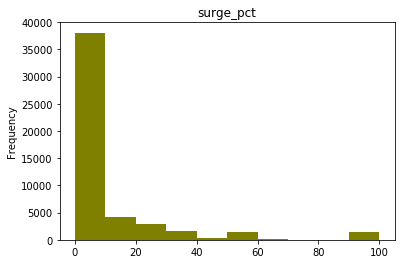

In [18]:
data_df['surge_pct'].plot(kind='hist', color='olive')
plt.title('surge_pct')
plt.show()

Most users had a small percentage of trips that occurred with surge multipliers > 1, though some did have more of their rides during such times. Some had them at around 100% of the time, which could reflect first-timers who then avoided the service.

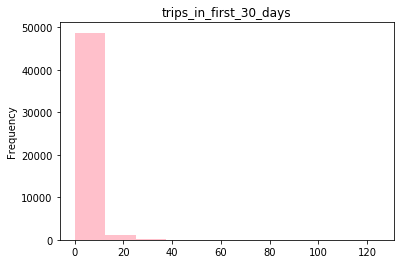

In [19]:
data_df['trips_in_first_30_days'].plot(kind='hist', color='pink')
plt.title('trips_in_first_30_days')
plt.show()

Most people took few trips within their first month of signup.

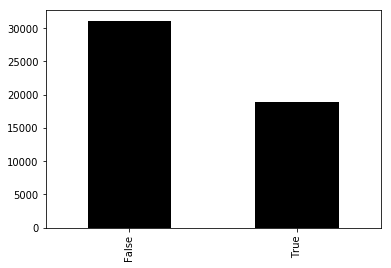

In [20]:
data_df['ultimate_black_user'].value_counts().plot(kind='bar', color='black')
plt.show()

Slightly fewer people were Ultimate Black users than did not use that service.

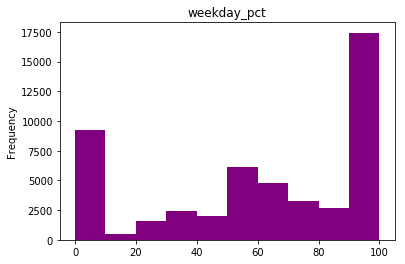

In [21]:
data_df['weekday_pct'].plot(kind='hist', color='purple')
plt.title('weekday_pct')
plt.show()

Usage of the service on weekdays by users was high, though another tail occurred for those who did not use it during weekdays.

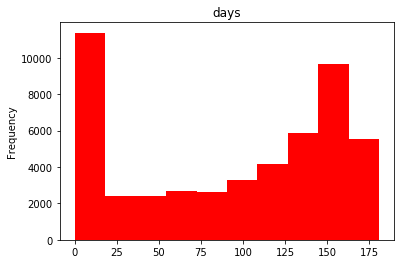

In [22]:
(data_df['days'] / np.timedelta64(1, 'D')).plot(kind='hist', color='red')
plt.title('days')
plt.show()

The days feature, the target that is a composite of signup date subtracted from last trip date, showed a spike around people using the service only briefly. Another spike occurs in the figure around 150 days, with high frequencies for bins around it, indicating a cohort of people with some longevity with the service.

In [23]:
data_df['days']=(data_df['days'] / np.timedelta64(1, 'D'))

In [24]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days                      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 4.6+ MB


In [25]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47.0


## Exploratory data analysis

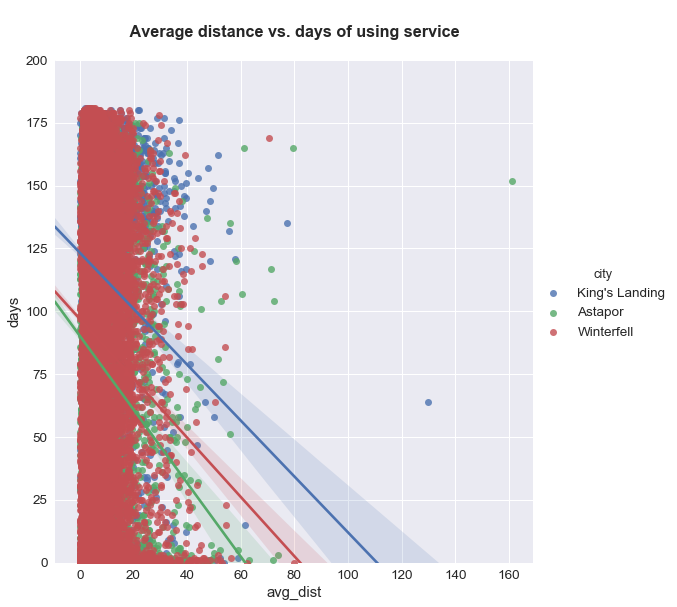

In [92]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_dist', y='days', data=data_df, hue='city',size=8)
plt.title('\n Average distance vs. days of using service \n', fontweight='bold')

axes = plt.gca()
axes.set_ylim([0,200])

plt.show()

This is a messier chart and not extremely useful, but most of the time people traveled within about 30 miles, regardless of signup city. 

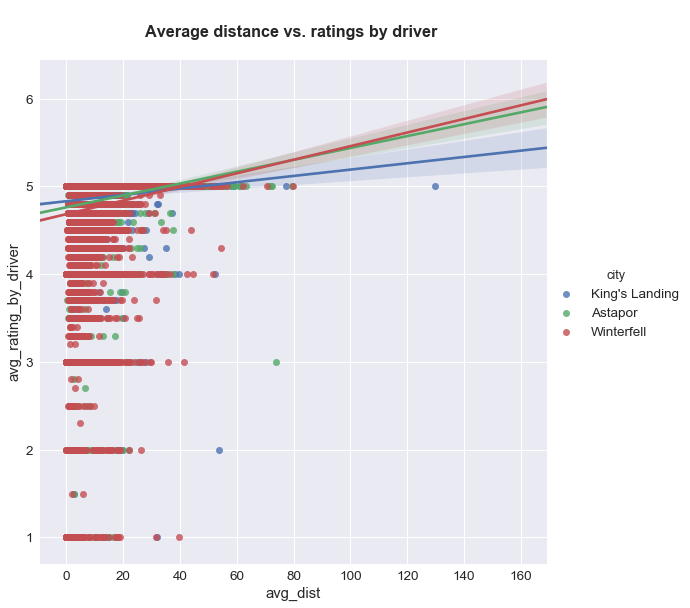

In [27]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_dist', y='avg_rating_by_driver', data=data_df, hue='city',size=8)
plt.title('\nAverage distance vs. ratings by driver \n', fontweight='bold')
plt.show()

Distance traveled together did not seem to negatively affect ratings drivers gave to riders in any city. 

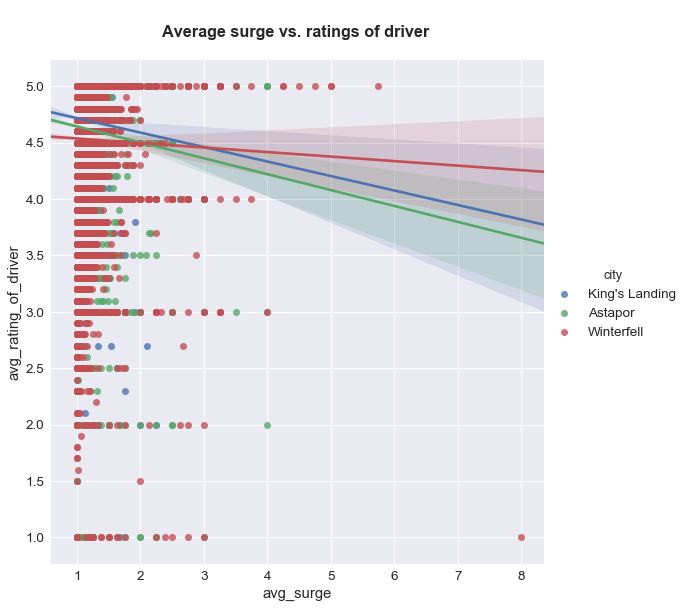

In [28]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_surge', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nAverage surge vs. ratings of driver \n', fontweight='bold')
plt.show()

Most people's surge multiplier was 1, but for those rides that were higher than 1, there may be a slight trend, as seen in the trend lines, toward lower ratings of drivers, but the confidence intervals are large, and it is is not an immediately obvious relationship from the figure. 

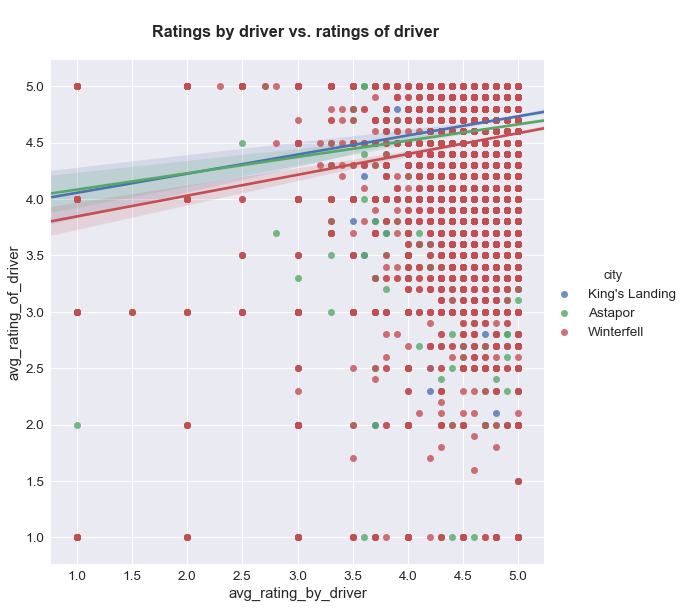

In [29]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_rating_by_driver', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nRatings by driver vs. ratings of driver \n', fontweight='bold')
plt.show()

Most drivers and riders were generous in ratings. Drivers in Winterfell had a slight trend toward lower ratings of drivers, but with so many more riders coming from this area it is hard to tell what the reason is. Lower ratings of drivers populate more space on this figure than do lower ratings by drivers.

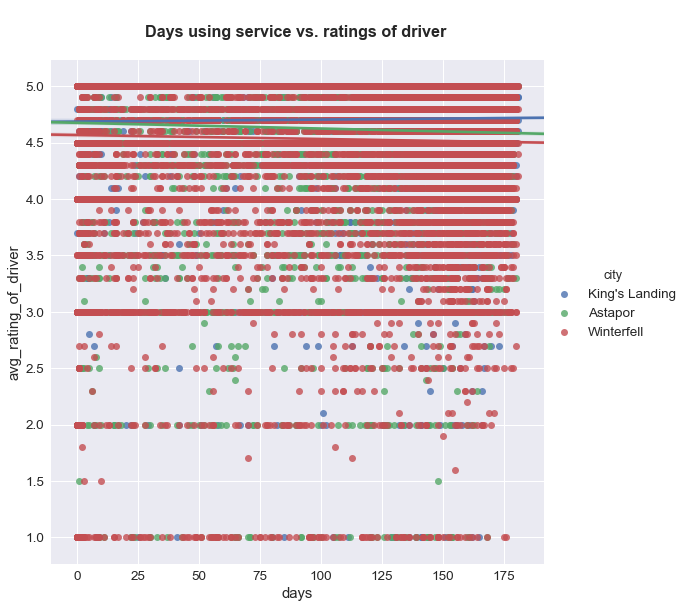

In [30]:
sns.set(font_scale=1.35)
sns.lmplot(x='days', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nDays using service vs. ratings of driver \n', fontweight='bold')
plt.show()

The trendlines for this figure suggest there was not a strong effect on ratings of drivers based on how many days since a rider had signed up before the ride. The data points themselves are hard to judge this by, as the use of a discrete y-variable here means some data points may be overlapping in different portions of the figure, but the trendlines are more meaningful.


Heatmap of correlations between variables


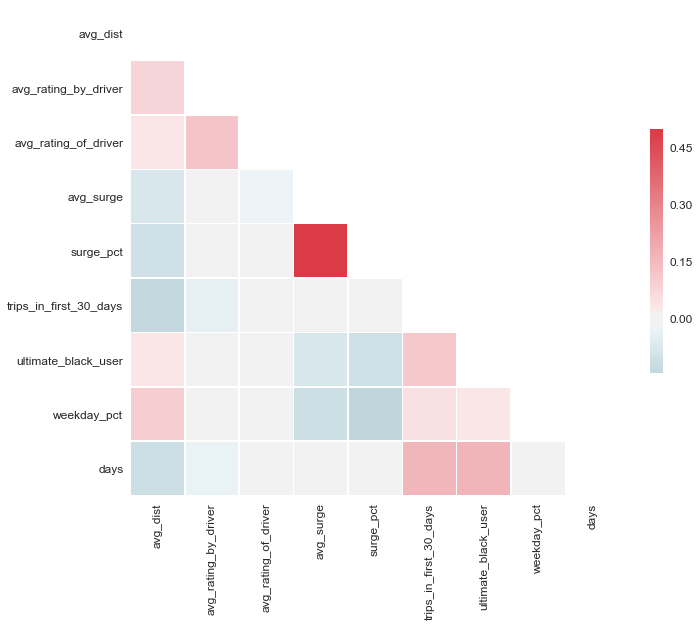

In [31]:
#adapted from code at https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white", font_scale=1.20)
corr = data_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# mask upper triangle by replacing values with 0 and masking zeros
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print('\033[1m' + "\nHeatmap of correlations between variables")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Most features are not very highly correlated with each other here or with the target variable, days. However, the average surge multiplier and percent of trips taken with a surge multiplier >1 are strongly correlated, which is not surprising.

In [33]:
data_df['chi_days'] = (pd.cut(data_df['days'], 8))

def Chi2test(colV, colZ, alpha=0.001):
    V = data_df[colV].astype(str)
    Z = data_df[colZ].astype(str)        
    obs = pd.crosstab(Z,V) 
    chi2, p, dof, expected = stats.chi2_contingency(obs.values)        
    Expected = pd.DataFrame(expected, columns=obs.columns, index = obs.index)
    if p<alpha:
        result="\033[1m {} with {}:".format(colV,colZ)
    else:
        result="\033[0m {} with {}:".format(colV,colZ)
    print(result, f"Chi-square stat. = {round(chi2,2)}, p = {round(p,5)}")
    
print('\033[4m\033[1m\nChi-square statistics and p-values (p) for relationships between categorical variables:\n\033[0m')  
Columns = ['city', 'phone', 'ultimate_black_user', 'chi_days']
for g,h in itertools.combinations(Columns,2):
    Chi2test(g,h) 


Chi-square statistics and p-values (p) for relationships between categorical variables:

 city with phone: Chi-square stat. = 187.85, p = 0.0
 city with ultimate_black_user: Chi-square stat. = 149.87, p = 0.0
 city with chi_days: Chi-square stat. = 3250.75, p = 0.0
 phone with ultimate_black_user: Chi-square stat. = 362.71, p = 0.0
 phone with chi_days: Chi-square stat. = 2353.64, p = 0.0
 ultimate_black_user with chi_days: Chi-square stat. = 1840.32, p = 0.0


Categorical variables here show strong chi-squared relationships. "Chi-days" is a variable included for just this analysis in order to adjust number of days into bins for categorical comparisons. City, phone, usage of Ultimate Black, and number of days with the service are all significantly related according to chi-squared analyses.

In [34]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days,chi_days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143.0,"(135.75, 158.375]"
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96.0,"(90.5, 113.125]"
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1.0,"(-0.181, 22.625]"
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170.0,"(158.375, 181.0]"
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47.0,"(45.25, 67.875]"


In [35]:
data_df = data_df.drop('chi_days', axis=1)

In [ ]:
#avg_rating_by_driver, avg_rating_of_driver, and phone all have missing data, so will impute now.
#some sklearn classifiers are ok with imputing, but not all are, and it's not clear which classifier is best yet.
#mode will work best for each because they are categoricals with an obviously most common value in each.

In [36]:
avg_rating_by_driver_mode = data_df.avg_rating_by_driver.mode()
data_df['avg_rating_by_driver'] = data_df.avg_rating_by_driver.fillna(avg_rating_by_driver_mode[0])

avg_rating_of_driver_mode = data_df.avg_rating_of_driver.mode()
data_df['avg_rating_of_driver'] = data_df.avg_rating_of_driver.fillna(avg_rating_of_driver_mode[0])

phone_mode = data_df.phone.mode()
data_df['phone'] = data_df.phone.fillna(phone_mode[0])

In [70]:
def pearson(colA, colB, alpha=0.001):
    A = data_df[colA].astype(float)
    B = data_df[colB].astype(float) 
    
    r, p = pearsonr(B,A)
    if p<alpha:
        result="\033[1m {} with {}:".format(colA,colB)
    else:
        result="\033[0m {} with {}:".format(colA,colB)
    print(result, f"Pearson r = {round(r,3)}, p = {round(p,5)}")

print('\033[4m\033[1m\nPearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:\n\033[0m')
cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 
        'ultimate_black_user', 'weekday_pct', 'days']
for e,f in itertools.combinations(cols,2):
    pearson(e,f)


Pearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:

 avg_dist with avg_rating_by_driver: Pearson r = 0.08, p = 0.0
 avg_dist with avg_rating_of_driver: Pearson r = 0.061, p = 0.0
 avg_dist with avg_surge: Pearson r = -0.081, p = 0.0
 avg_dist with surge_pct: Pearson r = -0.104, p = 0.0
 avg_dist with trips_in_first_30_days: Pearson r = -0.136, p = 0.0
 avg_dist with ultimate_black_user: Pearson r = 0.032, p = 0.0
 avg_dist with weekday_pct: Pearson r = 0.102, p = 0.0
 avg_dist with days: Pearson r = -0.109, p = 0.0
 avg_rating_by_driver with avg_rating_of_driver: Pearson r = 0.1, p = 0.0
 avg_rating_by_driver with avg_surge: Pearson r = 0.011, p = 0.01143
 avg_rating_by_driver with surge_pct: Pearson r = 0.021, p = 0.0
 avg_rating_by_driver with trips_in_first_30_days: Pearson r = -0.04, p = 0.0
 avg_rating_by_driver with ultimate_black_user: Pearson r = 0.008, p = 0.05836
 avg_rating_by_driver with weekday_pct: Pearson r = 0.02, p = 

Many relationships among continuous variables, including number of days with the service, show signficant relationships, even if the Pearson r values are not high. Average distance, for instance, correlates with high ratings both by and of drivers, usage of Ultimate Black, and both weekdays and total days with the service. There are, however, slightly negative relationships between average distance and the surge variables. None of that is surprising (including the fact that people do not want to travel far with the service during surge pricing, most likely). Very few relationships are not statistically signficant overall, at even p<0.05. 

## Preparation for predictive analysis

In [37]:
#Make dummy variables
data_df_dum = pd.get_dummies(data_df)
print(data_df_dum.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

  last_trip_date signup_date  surge_pct  trips_in_first_30_days  \
0     2014-06-17  2014-01-25       15.4                       4   
1     2014-05-05  2014-01-29        0.0                       0   
2     2014-01-07  2014-01-06        0.0                       3   
3     2014-06-29  2014-01-10       20.0                       9   
4     2014-03-15  2014-01-27       11.8                      14   

   ultimate_black_user  weekday_pct   days  city_Astapor  city_King's Landing  \
0                 True         46.2  143.0             0                    1   
1             

In [ ]:
#sklearn fails with datetime if floats present. Can convert them to integers, but their presence is not helpful anyway,
#as the target variable, days, is a composite of them anyway.

In [38]:
data_df_dum = data_df_dum.drop(['last_trip_date', 'signup_date'], axis=1)

In [39]:
data_df_dum.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,143.0,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,96.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,1.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,170.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,47.0,0,0,1,1,0


In [40]:
#(days >= 153).values

X = data_df_dum.drop('days', axis = 1)
y = (data_df_dum.days >= 153).values


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, stratify=y)

## Predictive analyses using machine learning

Accuracy on training data: 0.997
Accuracy on test data: 0.772
             precision    recall  f1-score   support

      False       0.83      0.89      0.86      9701
       True       0.49      0.38      0.43      2799

avg / total       0.75      0.77      0.76     12500

[[8587 1114]
 [1739 1060]]
AU-ROC score for Extra Trees model: 0.7642


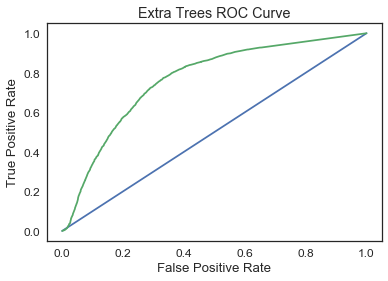

In [41]:

extra = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
extra.fit(X_train, y_train)

print('Accuracy on training data:',round(extra.score(X_train, y_train),3))
print('Accuracy on test data:',round(extra.score(X_test, y_test),3))
extra_pred = extra.predict(X_test)
print(classification_report(y_test,extra_pred))
print(confusion_matrix(y_test,extra_pred))

ey_pred_prob = extra.predict_proba(X_test)[:,1]
print('AU-ROC score for Extra Trees model:', round(roc_auc_score(y_test, ey_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ey_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Extra Trees Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve')
plt.show()

Basic Random Forest accuracy on training data: 0.997
Basic Random Forest accuracy on test data: 0.778
             precision    recall  f1-score   support

      False       0.83      0.90      0.86      9701
       True       0.50      0.37      0.42      2799

avg / total       0.76      0.78      0.76     12500

[[8694 1007]
 [1772 1027]]
AU-ROC score for Random Forest model: 0.777


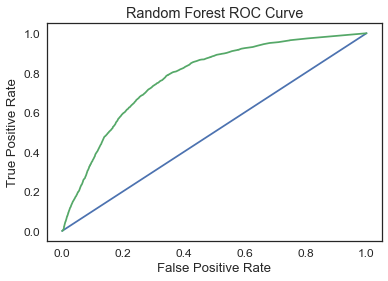

In [46]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rf.fit(X_train, y_train)
print('Basic Random Forest accuracy on training data:',round(rf.score(X_train, y_train),3))
print('Basic Random Forest accuracy on test data:',round(rf.score(X_test, y_test),3))
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test, rf_pred))

ry_pred_prob = rf.predict_proba(X_test)[:,1]
print('AU-ROC score for Random Forest model:', round(roc_auc_score(y_test, ry_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ry_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Random forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

Accuracy on training data: 0.977
Accuracy on test data: 0.789
             precision    recall  f1-score   support

      False       0.84      0.91      0.87      9701
       True       0.54      0.38      0.45      2799

avg / total       0.77      0.79      0.77     12500

[[8790  911]
 [1732 1067]]
AU-ROC score for XGBoost model: 0.7852


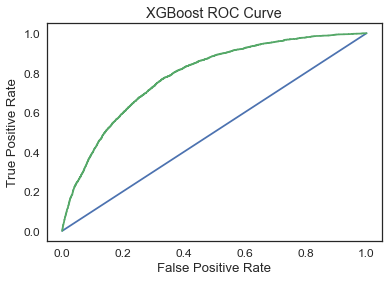

In [69]:
#kills kernel half the time

xgbo = XGBClassifier(max_depth=20, max_learning_rate=0.01)
#xgbo = XGBClassifier()
xgbo.fit(X_train, y_train)
xy_pred = xgbo.predict(X_test)
predictionsx = [round(value) for value in xy_pred]
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Accuracy on training data:',round(xgbo.score(X_train, y_train),3))
print('Accuracy on test data:',round(xgbo.score(X_test, y_test),3))
print(classification_report(y_test,xy_pred))
print(confusion_matrix(y_test,xy_pred))

xy_pred_prob = xgbo.predict_proba(X_test)[:,1]
print('AU-ROC score for XGBoost model:', round(roc_auc_score(y_test, xy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, xy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.show()

Accuracy on training data: 0.811
Accuracy on test data: 0.809
             precision    recall  f1-score   support

      False       0.84      0.94      0.88      9701
       True       0.63      0.36      0.46      2799

avg / total       0.79      0.81      0.79     12500

[[9116  585]
 [1798 1001]]
AU-ROC score for Gradient Boost model: 0.8185


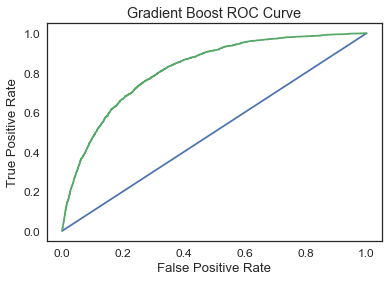

In [51]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gy_pred = gbc.predict(X_test)
print('Accuracy on training data:',round(gbc.score(X_train, y_train),3))
print('Accuracy on test data:',round(gbc.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))

gy_pred_prob = gbc.predict_proba(X_test)[:,1]
print('AU-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve')
plt.show()

Accuracy on training data: 0.997
Accuracy on test data: 0.733
             precision    recall  f1-score   support

      False       0.83      0.83      0.83      9701
       True       0.40      0.39      0.40      2799

avg / total       0.73      0.73      0.73     12500

[[8062 1639]
 [1696 1103]]
AU-ROC score for Decision Tree model: 0.6132


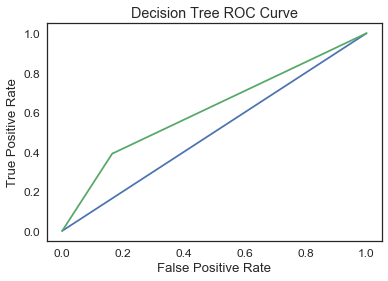

In [49]:
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)
dy_pred = dt.predict(X_test)
print('Accuracy on training data:',round(dt.score(X_train, y_train),3))
print('Accuracy on test data:',round(dt.score(X_test, y_test),3))
print(classification_report(y_test,dy_pred))
print(confusion_matrix(y_test,dy_pred))

dy_pred_prob = dt.predict_proba(X_test)[:,1]
print('AU-ROC score for Decision Tree model:', round(roc_auc_score(y_test, dy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, dy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

Accuracy on training data: 0.678
Accuracy on test data: 0.683
             precision    recall  f1-score   support

      False       0.87      0.69      0.77      9701
       True       0.38      0.64      0.48      2799

avg / total       0.76      0.68      0.71     12500

[[6733 2968]
 [ 998 1801]]
AU-ROC score for Logistic Regression model: 0.7299


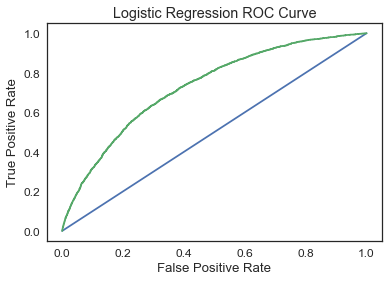

In [50]:
logr = LogisticRegression(class_weight='balanced')
logr.fit(X_train, y_train)
ly_pred = logr.predict(X_test)
print('Accuracy on training data:',round(logr.score(X_train, y_train),3))
print('Accuracy on test data:',round(logr.score(X_test, y_test),3))
print(classification_report(y_test,ly_pred))
print(confusion_matrix(y_test,ly_pred))

ly_pred_prob = logr.predict_proba(X_test)[:,1]
print('AU-ROC score for Logistic Regression model:', round(roc_auc_score(y_test, ly_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ly_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

Accuracy on training data: 0.803
Accuracy on test data: 0.803
             precision    recall  f1-score   support

      False       0.83      0.94      0.88      9701
       True       0.61      0.34      0.43      2799

avg / total       0.78      0.80      0.78     12500

[[9093  608]
 [1858  941]]
AU-ROC score for AdaBoost model: 0.8117


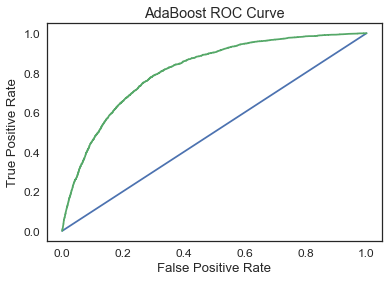

In [52]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
ay_pred = abc.predict(X_test)
print('Accuracy on training data:',round(abc.score(X_train, y_train),3))
print('Accuracy on test data:',round(abc.score(X_test, y_test),3))
print(classification_report(y_test,ay_pred))
print(confusion_matrix(y_test,ay_pred))

ay_pred_prob = abc.predict_proba(X_test)[:,1]
print('AU-ROC score for AdaBoost model:', round(roc_auc_score(y_test, ay_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ay_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.show()

Accuracy on training data: 0.796
Accuracy on test data: 0.8
             precision    recall  f1-score   support

      False       0.85      0.90      0.88      9701
       True       0.57      0.44      0.49      2799

avg / total       0.79      0.80      0.79     12500

[[8775  926]
 [1576 1223]]
AU-ROC score for MLP model: 0.7983


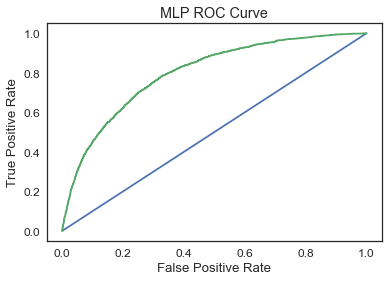

In [57]:
from sklearn.neural_network import MLPClassifier 

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
my_pred = mlp.predict(X_test)
print('Accuracy on training data:',round(mlp.score(X_train, y_train),3))
print('Accuracy on test data:',round(mlp.score(X_test, y_test),3))
print(classification_report(y_test,my_pred))
print(confusion_matrix(y_test,my_pred))

my_pred_prob = mlp.predict_proba(X_test)[:,1]
print('AU-ROC score for MLP model:', round(roc_auc_score(y_test, my_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, my_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.show()

Accuracy on training data: 0.735
Accuracy on test data: 0.742
             precision    recall  f1-score   support

      False       0.87      0.79      0.83      9701
       True       0.44      0.58      0.50      2799

avg / total       0.77      0.74      0.75     12500

[[7651 2050]
 [1179 1620]]
AU-ROC score for GNB model: 0.7398


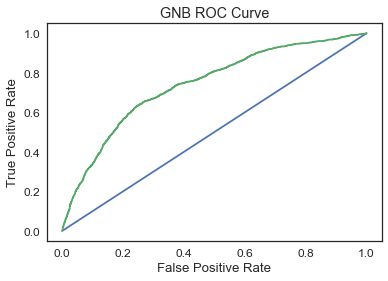

In [54]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gy_pred = gnb.predict(X_test)
print('Accuracy on training data:',round(gnb.score(X_train, y_train),3))
print('Accuracy on test data:',round(gnb.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))

gy_pred_prob = gnb.predict_proba(X_test)[:,1]
print('AU-ROC score for GNB model:', round(roc_auc_score(y_test, gy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='GNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GNB ROC Curve')
plt.show()

Accuracy on training data: 0.712
Accuracy on test data: 0.714
             precision    recall  f1-score   support

      False       0.82      0.81      0.82      9701
       True       0.37      0.37      0.37      2799

avg / total       0.72      0.71      0.72     12500

[[7884 1817]
 [1754 1045]]
AU-ROC score for MNB model: 0.6659


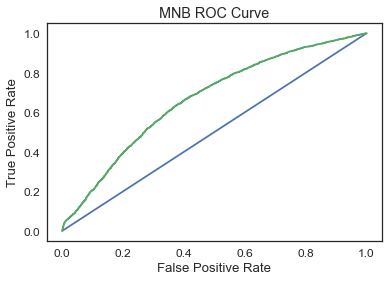

In [53]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mny_pred = mnb.predict(X_test)
print('Accuracy on training data:',round(mnb.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnb.score(X_test, y_test),3))
print(classification_report(y_test,mny_pred))
print(confusion_matrix(y_test,mny_pred))

mny_pred_prob = mnb.predict_proba(X_test)[:,1]
print('AU-ROC score for MNB model:', round(roc_auc_score(y_test, mny_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, mny_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MNB ROC Curve')
plt.show()

In [60]:
from sklearn import svm
sv = svm.SVC()
sv.fit(X_train, y_train)
print('Accuracy on training data:',round(sv.score(X_train, y_train),3))
print('Accuracy on test data:',round(sv.score(X_test, y_test),3))

sv_pred = sv.predict(X_test)
print(classification_report(y_test,sv_pred))
print(confusion_matrix(y_test,sv_pred))


Accuracy on training data: 0.844
Accuracy on test data: 0.796
             precision    recall  f1-score   support

      False       0.82      0.94      0.88      9701
       True       0.59      0.28      0.38      2799

avg / total       0.77      0.80      0.77     12500

[[9150  551]
 [2003  796]]


In [59]:
svlin = svm.LinearSVC()
svlin.fit(X_train, y_train)
print('Accuracy on training data:',round(svlin.score(X_train, y_train),3))
print('Accuracy on test data:',round(svlin.score(X_test, y_test),3))

svlin_pred = svlin.predict(X_test)
print(classification_report(y_test,svlin_pred))


Accuracy on training data: 0.381
Accuracy on test data: 0.392
             precision    recall  f1-score   support

      False       0.91      0.24      0.38      9701
       True       0.26      0.92      0.40      2799

avg / total       0.76      0.39      0.39     12500



## Hyperparameter tuning on the most promising classifiers

In [62]:
#tuning
param_grid = {'n_estimators' : [1,9,36,200], 'max_depth': [1,3,9], 'min_samples_leaf': [1,3,10]}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)
print(CV_rf.best_score_)
print(CV_rf.best_estimator_)

{'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 200}
0.7476
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [64]:
#tuned rf
rf_tuned = CV_rf.best_estimator_
rf_tuned.fit(X_train, y_train)
ty_true, ty_predict = y_test, rf_tuned.predict(X_test)
print('Tuned random forest accuracy on training data:',round(rf_tuned.score(X_train, y_train),3))
print('Tuned random forest accuracy on test data:',round(rf_tuned.score(X_test, y_test),3))

try_pred_prob = rf_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned Random Forest model:', round(roc_auc_score(y_test, try_pred_prob),4))
print('\nClassification report:\n',classification_report(ty_true,ty_predict))
print('Confusion matrix:\n',confusion_matrix(ty_true,ty_predict))

Tuned random forest accuracy on training data: 0.764
Tuned random forest accuracy on test data: 0.744
AU-ROC score for Tuned Random Forest model: 0.8157

Classification report:
              precision    recall  f1-score   support

      False       0.90      0.75      0.82      9701
       True       0.45      0.72      0.56      2799

avg / total       0.80      0.74      0.76     12500

Confusion matrix:
 [[7283 2418]
 [ 787 2012]]


In [66]:
param_grid = {'n_estimators' : [1,9,36,200], 'max_depth': [1,3,9], 'min_samples_leaf': [1,3,10]}
CV_et = GridSearchCV(estimator=extra, param_grid=param_grid, cv=5)
CV_et.fit(X_train, y_train)
print(CV_et.best_params_)
print(CV_et.best_score_)
print(CV_et.best_estimator_)

{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 200}
0.70496
ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=9, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [68]:
#tuned et
et_tuned = CV_et.best_estimator_
et_tuned.fit(X_train, y_train)
tey_true, tey_predict = y_test, et_tuned.predict(X_test)
print('Tuned ET accuracy on training data:',round(et_tuned.score(X_train, y_train),3))
print('Tuned ET accuracy on test data:',round(et_tuned.score(X_test, y_test),3))

tey_pred_prob = et_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned ET model:', round(roc_auc_score(y_test, tey_pred_prob),4))
print('\nClassification report:\n',classification_report(tey_true,tey_predict))
print('Confusion matrix:\n',confusion_matrix(tey_true,tey_predict))

Tuned ET accuracy on training data: 0.712
Tuned ET accuracy on test data: 0.715
AU-ROC score for Tuned ET model: 0.7951

Classification report:
              precision    recall  f1-score   support

      False       0.91      0.70      0.79      9701
       True       0.42      0.76      0.54      2799

avg / total       0.80      0.71      0.74     12500

Confusion matrix:
 [[6808 2893]
 [ 673 2126]]


In [80]:
gb_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],'max_depth': [4, 6, 8],'min_samples_leaf': [20,50,100]}

CV_gbc = GridSearchCV(estimator=gbc, param_grid=gb_params, cv=5)
CV_gbc.fit(X_train, y_train)
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)
print(CV_gbc.best_estimator_)

{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 100}
0.806586666667
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [81]:
gbc_tuned = CV_gbc.best_estimator_
gbc_tuned.fit(X_train, y_train)
gty_pred = gbc_tuned.predict(X_test)
print('Accuracy on training data:',round(gbc_tuned.score(X_train, y_train),3))
print('Accuracy on test data:',round(gbc_tuned.score(X_test, y_test),3))
print(classification_report(y_test,gty_pred))
print(confusion_matrix(y_test,gty_pred))

gty_pred_prob = gbc_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gty_pred_prob),4))

Accuracy on training data: 0.819
Accuracy on test data: 0.81
             precision    recall  f1-score   support

      False       0.84      0.94      0.88      9701
       True       0.62      0.37      0.47      2799

avg / total       0.79      0.81      0.79     12500

[[9074  627]
 [1754 1045]]
AU-ROC score for Tuned Gradient Boost model: 0.8187


In [86]:
ab_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01]}


CV_abc = GridSearchCV(estimator=abc, param_grid=ab_params, cv=5)
CV_abc.fit(X_train, y_train)
print(CV_abc.best_params_)
print(CV_abc.best_score_)
print(CV_abc.best_estimator_)

{'learning_rate': 0.1}
0.782933333333
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


In [88]:
abc_tuned = CV_abc.best_estimator_
abc_tuned.fit(X_train, y_train)
aty_pred = abc_tuned.predict(X_test)
print('Accuracy on training data:',round(abc_tuned.score(X_train, y_train),3))
print('Accuracy on test data:',round(abc_tuned.score(X_test, y_test),3))
print(classification_report(y_test,aty_pred))
print(confusion_matrix(y_test,aty_pred))

aty_pred_prob = abc_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned AdaBoost model:', round(roc_auc_score(y_test, aty_pred_prob),4))

Accuracy on training data: 0.784
Accuracy on test data: 0.786
             precision    recall  f1-score   support

      False       0.79      0.99      0.88      9701
       True       0.66      0.09      0.16      2799

avg / total       0.76      0.79      0.72     12500

[[9571  130]
 [2544  255]]
AU-ROC score for Tuned AdaBoost model: 0.7966


In [102]:
mlp_params = {'learning_rate': ["constant", "invscaling", "adaptive"], 'hidden_layer_sizes':[(100,10), (100,30)]}


CV_mlp = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5)
CV_mlp.fit(X_train, y_train)
print(CV_mlp.best_params_)
print(CV_mlp.best_score_)
print(CV_mlp.best_estimator_)

{'hidden_layer_sizes': (100, 10), 'learning_rate': 'invscaling'}
0.79808
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [103]:
mlp_tuned = CV_mlp.best_estimator_
mlp_tuned.fit(X_train, y_train)
mty_pred = mlp_tuned.predict(X_test)
print('Accuracy on training data:',round(mlp_tuned.score(X_train, y_train),3))
print('Accuracy on test data:',round(mlp_tuned.score(X_test, y_test),3))
print(classification_report(y_test,mty_pred))
print(confusion_matrix(y_test,mty_pred))

mty_pred_prob = mlp_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned MLP model:', round(roc_auc_score(y_test, mty_pred_prob),4))

Accuracy on training data: 0.801
Accuracy on test data: 0.805
             precision    recall  f1-score   support

      False       0.84      0.92      0.88      9701
       True       0.60      0.39      0.47      2799

avg / total       0.79      0.80      0.79     12500

[[8965  736]
 [1707 1092]]
AU-ROC score for Tuned AdaBoost model: 0.7989


Since target class is an imbalanced class, it is appropriate to consider an alternate sampling method to apply to the data. For some of the classifiers a class weighting function is already available at the time of analysis, and that has been used where available above. While there are numerous ways of handling this (over-, under-, resampling, adjustment of sample weights), the option we will consider here is SMOTE, which generates synthetic samples of the minority class based on sampling of nearest neighbor distances between samples. Next are shown results of re-running untuned tests of the extra trees, random forest, gradient boosting, and AdaBoost classifiers using SMOTE-treated training data. Even though class weight is already balanced in some classifiers, there is a possibility of SMOTE being helpful. After comparing all results, then retuning of only the top classifier (since that takes a lot of time) is done with SMOTE-treated data if it appears Smote treatment is useful.

Metrics of model success include AUC-ROC score, accuracy on test data, F1 score, and the makeup of precision and recall for each target class. It should be noted that the target class is about 77-78% represented by the majority (those not using the service into their sixth month), so any model that is deemed successful should have metrics above that value.

## Addressing imbalance

In [93]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(kind='regular')
Xsm, ysm = smote.fit_sample(X_train, y_train)


Accuracy on training data: 0.998
Accuracy on test data: 0.764
             precision    recall  f1-score   support

      False       0.85      0.85      0.85      9701
       True       0.47      0.46      0.47      2799

avg / total       0.76      0.76      0.76     12500

[[8265 1436]
 [1516 1283]]
AU-ROC score for Extra Trees model: 0.7622


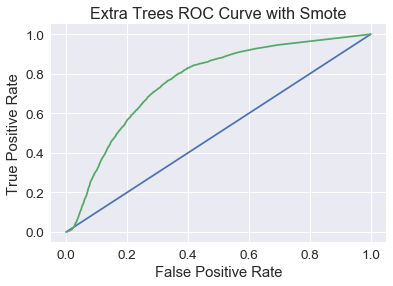

In [94]:
extrasm = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
extrasm.fit(Xsm, ysm)

print('Accuracy on training data:',round(extrasm.score(Xsm, ysm),3))
print('Accuracy on test data:',round(extrasm.score(X_test, y_test),3))
extrasm_pred = extrasm.predict(X_test)
print(classification_report(y_test,extrasm_pred))
print(confusion_matrix(y_test,extrasm_pred))

esmy_pred_prob = extrasm.predict_proba(X_test)[:,1]
print('AU-ROC score for Extra Trees model:', round(roc_auc_score(y_test, esmy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, esmy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Extra Trees Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve with Smote')
plt.show()

Basic Random Forest accuracy on training data: 0.998
Basic Random Forest accuracy on test data: 0.766
             precision    recall  f1-score   support

      False       0.85      0.85      0.85      9701
       True       0.48      0.47      0.47      2799

avg / total       0.76      0.77      0.77     12500

[[8275 1426]
 [1495 1304]]
AU-ROC score for Random Forest model: 0.7727


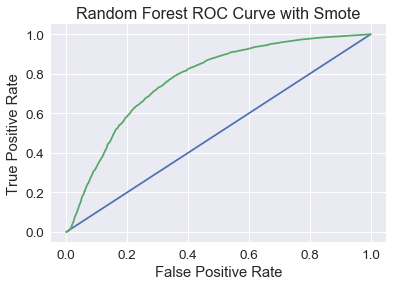

In [95]:
rfsm = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfsm.fit(Xsm,ysm)
print('Basic Random Forest accuracy on training data:',round(rfsm.score(Xsm,ysm),3))
print('Basic Random Forest accuracy on test data:',round(rfsm.score(X_test, y_test),3))
rfsm_pred = rfsm.predict(X_test)
print(classification_report(y_test,rfsm_pred))
print(confusion_matrix(y_test, rfsm_pred))

rsmy_pred_prob = rfsm.predict_proba(X_test)[:,1]
print('AU-ROC score for Random Forest model:', round(roc_auc_score(y_test, rsmy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, rsmy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Random forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve with Smote')
plt.show()

Accuracy on training data: 0.834
Accuracy on test data: 0.786
             precision    recall  f1-score   support

      False       0.86      0.86      0.86      9701
       True       0.52      0.53      0.53      2799

avg / total       0.79      0.79      0.79     12500

[[8335 1366]
 [1304 1495]]
AU-ROC score for Gradient Boost model: 0.8044


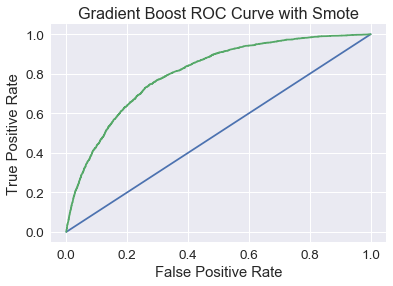

In [96]:
gbcsm = GradientBoostingClassifier()
gbcsm.fit(Xsm,ysm)
gsmy_pred = gbcsm.predict(X_test)
print('Accuracy on training data:',round(gbcsm.score(Xsm,ysm),3))
print('Accuracy on test data:',round(gbcsm.score(X_test, y_test),3))
print(classification_report(y_test,gsmy_pred))
print(confusion_matrix(y_test,gsmy_pred))

gsmy_pred_prob = gbcsm.predict_proba(X_test)[:,1]
print('AU-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gsmy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gsmy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve with Smote')
plt.show()

Accuracy on training data: 0.81
Accuracy on test data: 0.776
             precision    recall  f1-score   support

      False       0.87      0.84      0.85      9701
       True       0.50      0.56      0.53      2799

avg / total       0.79      0.78      0.78     12500

[[8123 1578]
 [1220 1579]]
AU-ROC score for AdaBoost model: 0.7947


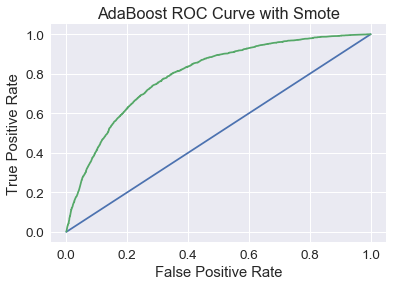

In [97]:
abcsm = AdaBoostClassifier()
abcsm.fit(Xsm,ysm)
asmy_pred = abcsm.predict(X_test)
print('Accuracy on training data:',round(abcsm.score(Xsm,ysm),3))
print('Accuracy on test data:',round(abcsm.score(X_test, y_test),3))
print(classification_report(y_test,asmy_pred))
print(confusion_matrix(y_test,asmy_pred))

asmy_pred_prob = abcsm.predict_proba(X_test)[:,1]
print('AU-ROC score for AdaBoost model:', round(roc_auc_score(y_test, asmy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, asmy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve with Smote')
plt.show()

Accuracy on training data: 0.733
Accuracy on test data: 0.75
             precision    recall  f1-score   support

      False       0.89      0.77      0.83      9701
       True       0.46      0.67      0.55      2799

avg / total       0.79      0.75      0.76     12500

[[7501 2200]
 [ 920 1879]]
AU-ROC score for MLP model with Smote: 0.7986


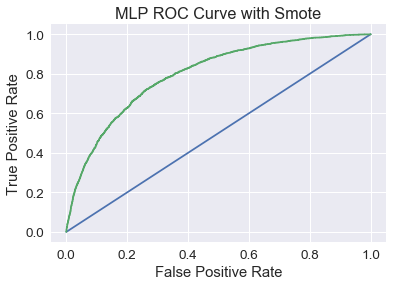

In [98]:
mlpsm = MLPClassifier()
mlpsm.fit(Xsm,ysm)
mysm_pred = mlpsm.predict(X_test)
print('Accuracy on training data:',round(mlpsm.score(Xsm,ysm),3))
print('Accuracy on test data:',round(mlpsm.score(X_test, y_test),3))
print(classification_report(y_test,mysm_pred))
print(confusion_matrix(y_test,mysm_pred))

msmy_pred_prob = mlpsm.predict_proba(X_test)[:,1]
print('AU-ROC score for MLP model with Smote:', round(roc_auc_score(y_test, msmy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, msmy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve with Smote')
plt.show()

## Choosing the most successful model

In [105]:
print('Extra Trees: regular, untuned')
print('Accuracy on test data:',round(extra.score(X_test, y_test),3))
print(classification_report(y_test,extra_pred))
print(confusion_matrix(y_test,extra_pred))
print('AU-ROC score for Extra Trees model:', round(roc_auc_score(y_test, ey_pred_prob),4))

print('\n\nRandom forest: regular, untuned')
print('Basic Random Forest accuracy on test data:',round(rf.score(X_test, y_test),3))
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test, rf_pred))
print('AU-ROC score for Random Forest model:', round(roc_auc_score(y_test, ry_pred_prob),4))

print('\n\nGBC: regular, untuned')
print('Accuracy on test data:',round(gbc.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))
print('AU-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gy_pred_prob),4))

print('\n\nAdaBoost: regular, untuned')
print('Accuracy on test data:',round(abc.score(X_test, y_test),3))
print(classification_report(y_test,ay_pred))
print(confusion_matrix(y_test,ay_pred))
print('AU-ROC score for AdaBoost model:', round(roc_auc_score(y_test, ay_pred_prob),4))

print('\n\nMLP: regular, untuned')
print('Accuracy on test data:',round(mlp.score(X_test, y_test),3))
print(classification_report(y_test,my_pred))
print(confusion_matrix(y_test,my_pred))
print('AU-ROC score for MLP model:', round(roc_auc_score(y_test, my_pred_prob),4))

print('\n\nExtra Trees: regular, tuned')
print('Tuned ET accuracy on test data:',round(et_tuned.score(X_test, y_test),3))
print(classification_report(tey_true,tey_predict))
print(confusion_matrix(tey_true,tey_predict))
print('AU-ROC score for Tuned ET model:', round(roc_auc_score(y_test, tey_pred_prob),4))

print('\n\nRandom forest: regular, tuned')
print('Tuned random forest accuracy on test data:',round(rf_tuned.score(X_test, y_test),3))
print(classification_report(ty_true,ty_predict))
print(confusion_matrix(ty_true,ty_predict))
print('AU-ROC score for Tuned Random Forest model:', round(roc_auc_score(y_test, try_pred_prob),4))

print('\n\nGBC: regular, tuned')
print('Accuracy on test data:',round(gbc_tuned.score(X_test, y_test),3))
print(classification_report(y_test,gty_pred))
print(confusion_matrix(y_test,gty_pred))
print('AU-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gty_pred_prob),4))

print('\n\nAdaBoost: regular, tuned')
print('Accuracy on test data:',round(abc_tuned.score(X_test, y_test),3))
print(classification_report(y_test,aty_pred))
print(confusion_matrix(y_test,aty_pred))
print('AU-ROC score for Tuned AdaBoost model:', round(roc_auc_score(y_test, aty_pred_prob),4))

print('\n\nMLP: regular, tuned')
print('Accuracy on test data:',round(mlp_tuned.score(X_test, y_test),3))
print(classification_report(y_test,mty_pred))
print(confusion_matrix(y_test,mty_pred))
print('AU-ROC score for Tuned MLP model:', round(roc_auc_score(y_test, mty_pred_prob),4))

print('\n\nET: smote, untuned')
print('Accuracy on test data:',round(extrasm.score(X_test, y_test),3))
extrasm_pred = extrasm.predict(X_test)
print(classification_report(y_test,extrasm_pred))
print(confusion_matrix(y_test,extrasm_pred))
print('AU-ROC score for Extra Trees model:', round(roc_auc_score(y_test, esmy_pred_prob),4))

print('\n\nRF: smote, untuned')
print('Basic Random Forest accuracy on test data:',round(rfsm.score(X_test, y_test),3))
rfsm_pred = rfsm.predict(X_test)
print(classification_report(y_test,rfsm_pred))
print(confusion_matrix(y_test, rfsm_pred))
print('AU-ROC score for Random Forest model:', round(roc_auc_score(y_test, rsmy_pred_prob),4))

print('\n\nGBC: smote, untuned')
print('Accuracy on test data:',round(gbcsm.score(X_test, y_test),3))
print(classification_report(y_test,gsmy_pred))
print(confusion_matrix(y_test,gsmy_pred))
print('AU-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gsmy_pred_prob),4))

print('\n\nAdaBoost: smote, untuned')
print('Accuracy on test data:',round(abcsm.score(X_test, y_test),3))
print(classification_report(y_test,asmy_pred))
print(confusion_matrix(y_test,asmy_pred))
print('AU-ROC score for AdaBoost model:', round(roc_auc_score(y_test, asmy_pred_prob),4))

print('\n\nMLP: smote, untuned')
print('Accuracy on test data:',round(mlpsm.score(X_test, y_test),3))
print(classification_report(y_test,mysm_pred))
print(confusion_matrix(y_test,mysm_pred))
print('AU-ROC score for MLP model with Smote:', round(roc_auc_score(y_test, msmy_pred_prob),4))

Extra Trees: regular, untuned
Accuracy on test data: 0.772
             precision    recall  f1-score   support

      False       0.83      0.89      0.86      9701
       True       0.49      0.38      0.43      2799

avg / total       0.75      0.77      0.76     12500

[[8587 1114]
 [1739 1060]]
AU-ROC score for Extra Trees model: 0.7642


Random forest: regular, untuned
Basic Random Forest accuracy on test data: 0.778
             precision    recall  f1-score   support

      False       0.83      0.90      0.86      9701
       True       0.50      0.37      0.42      2799

avg / total       0.76      0.78      0.76     12500

[[8694 1007]
 [1772 1027]]
AU-ROC score for Random Forest model: 0.777


GBC: regular, untuned
Accuracy on test data: 0.809
             precision    recall  f1-score   support

      False       0.87      0.79      0.83      9701
       True       0.44      0.58      0.50      2799

avg / total       0.77      0.74      0.75     12500

[[7651 2050]
 [1179

None of the models so far perform as well with the minority target class (those who stay with the service into their sixth month), but some do better than others. The results for each of these models are pretty similar to each other. In considering all metrics examined here, the gradient boosting classifier seems to perform the best with the tuned classifier providing relatively high AUC-ROC, accuracy, and F1 scores. The untuned gradient boosting classifier with SMOTE-treated training data appeared slightly more successful than without, so next this classifier will be tuned using SMOTE-treated data. 

In [107]:
gbs_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],'max_depth': [4, 6, 8],'min_samples_leaf': [20,50,100]}

CV_gbcs = GridSearchCV(estimator=gbcsm, param_grid=gbs_params, cv=5)
CV_gbcs.fit(Xsm,ysm)
print(CV_gbcs.best_params_)
print(CV_gbcs.best_score_)
print(CV_gbcs.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 20}
0.823569833362
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [108]:
gbcs_tuned = CV_gbcs.best_estimator_
gbcs_tuned.fit(Xsm,ysm)
gtsy_pred = gbcs_tuned.predict(X_test)
print('Accuracy on training data:',round(gbcs_tuned.score(Xsm,ysm),3))
print('Accuracy on test data:',round(gbcs_tuned.score(X_test, y_test),3))
print(classification_report(y_test,gtsy_pred))
print(confusion_matrix(y_test,gtsy_pred))

gtsy_pred_prob = gbcs_tuned.predict_proba(X_test)[:,1]
print('AU-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gtsy_pred_prob),4))

Accuracy on training data: 0.883
Accuracy on test data: 0.795
             precision    recall  f1-score   support

      False       0.85      0.89      0.87      9701
       True       0.55      0.45      0.50      2799

avg / total       0.78      0.80      0.79     12500

[[8673 1028]
 [1533 1266]]
AU-ROC score for Tuned Gradient Boost model: 0.8048


After retuning and running the gradient boosting classifier with SMOTE-treated training data, there was no real improvement owed to SMOTE. In fact, metrics are slightly worse here, though not by much. 

## Feature importance with the chosen gradient boosting model

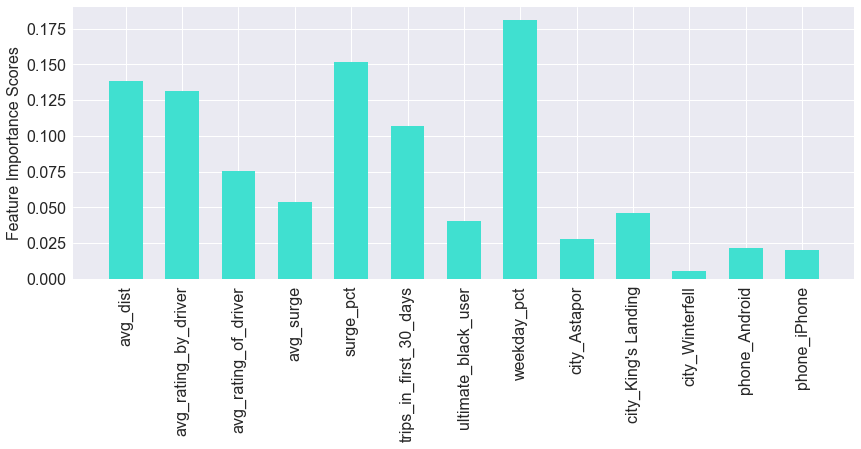

In [136]:
plt.figure(figsize=(14,5))
fi = gbc_tuned.feature_importances_
plt.bar(np.arange(13),fi, width=0.6, color='turquoise', label=name)
plt.xticks(np.arange(13),X[1:],rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Feature Importance Scores", fontsize=16)
plt.show()

With the tuned gradient boosting model, weekday pecentage of rides seems to be a strong predictor of a rider's longevity with the service. After weekday percentage, surge percentage is another strong feature here, followed by average distance. Next are average rating by driver, followed by number of trips in first 30 days. Following those features, most other features take on less importance, with phone type and city (apart from King's Landing) taking on the least importance.

## Individual feature importance with SHAP values

In [116]:
import shap
shap.initjs() 
#gbc_tuned is {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 100}
ksample = shap.kmeans(X_train, 1000)

In [160]:

shap_values = shap.KernelExplainer(gbc_tuned.predict_proba, ksample).shap_values(X_test.iloc[25,:])
shap.force_plot(shap_values[0], X_test.iloc[25,:])

Using 1000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [159]:
shap_values = shap.KernelExplainer(gbc_tuned.predict_proba, ksample).shap_values(X_test.iloc[42,:])
shap.force_plot(shap_values[0], X_test.iloc[42,:])

Using 1000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [162]:
y_test[25]

True

In [163]:
y_test[42]

False

Using the SHAP python package it is possible to get an individual feature map of the model target prediction plus the features and their values that contribute to the prediction. Here, it would be better for reporting purposes (and this would be something to adjust for an official report) to have switched the code so the map for individuals and for the group set examined in the next figures would show the right side corresponding to "True", but these SHAP analyses are computationally intensive with these data for my personal computer, so for our purposes right now we will just read in the other direction. Any features pointing to the right are driving the prediction toward "False" status, or a user without longevity into the sixth month, and vice versa for those pointing to the left.

For sample with index 25 from the test set (two plots above), the SHAP target prediction has a value of 0.28. The scale is relative to the dataset, so this is contrasted with the prediction for sample index 42 in the next plot, which has a prediction of 0.91. What this means is that someone who is likely to hold a "True" value for being a user within the sixth month has a low SHAP value, and vice versa. For these two individuals the model predicted accurately. However, this model does make some mistaken predictions. Examining multiple samples for SHAP values can sometimes illuminate which features may be problematic, always contributing to a confusing result. 

Sample 25 reflects an Ultimate Black user who has a high percentage of weekday usage of the service, and having a surge percentage of 4.1% was regarded as important to predicting long-term usage by this customer. The user's long average distance of 9.34 miles held the model back from making a stronger prediction of "True" for the target here.

Sample 42 travels a shorter average distance and has a weekday percentage over 50%, which both drive the prediction toward "True" for the target, but a number of features overwhelmingly trend the prediction toward "False"; however, it is not immediately evident from this small sampling why each feature corresponds in this way. Average rating by driver, for instance, is often 5 for many riders, but the classifier has to make a decision. However, here it shows up as having high importance, but perhaps this is considered by the model in conjunction with other features. We will consider effects of each feature below. 

In [164]:
#For reference
gbctIndiv_pred = gbc_tuned.predict(X_test)
print(list(zip(y_test,gbctIndiv_pred))[0:99])

[(True, False), (True, False), (False, False), (False, False), (True, True), (True, False), (True, True), (False, False), (False, False), (True, False), (False, False), (True, True), (False, False), (False, False), (False, False), (True, False), (False, False), (True, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (False, False), (True, True), (False, False), (False, False), (True, True), (False, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (True, True), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (True, True), (False, False), (False, False), (False, False), (True, True), (T

In [156]:
shap_values = shap.KernelExplainer(gbc_tuned.predict_proba, ksample).shap_values(X_test.iloc[0:99])
shap.force_plot(shap_values[0], X_test.iloc[0:99])

Using 1000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.




  0%|          | 0/99 [00:00<?, ?it/s]



  1%|          | 1/99 [00:55<1:31:15, 55.88s/it]



  2%|▏         | 2/99 [01:51<1:29:57, 55.64s/it]



  3%|▎         | 3/99 [02:49<1:30:37, 56.64s/it]



  4%|▍         | 4/99 [03:53<1:32:32, 58.45s/it]



  5%|▌         | 5/99 [04:52<1:31:37, 58.49s/it]



  6%|▌         | 6/99 [05:47<1:29:48, 57.94s/it]



  7%|▋         | 7/99 [06:42<1:28:15, 57.56s/it]



  8%|▊         | 8/99 [07:38<1:26:54, 57.30s/it]



  9%|▉         | 9/99 [08:33<1:25:37, 57.08s/it]



 10%|█         | 10/99 [09:29<1:24:29, 56.96s/it]



 11%|█         | 11/99 [10:24<1:23:19, 56.81s/it]



 12%|█▏        | 12/99 [11:19<1:22:07, 56.64s/it]



 13%|█▎        | 13/99 [12:15<1:21:05, 56.58s/it]



 14%|█▍        | 14/99 [13:17<1:20:44, 56.99s/it]



 15%|█▌        | 15/99 [14:17<1:20:04, 57.20s/it]



 16%|█▌        |

The figure above is best viewed interactively in a web browser because it incorporates a hover tool that allows the user to quickly examine the dominant features and model output scores for each individual in the dataset, in addition to allowing a collective view of the dataset. Most individuals here show up as being predicted as "False" for longevity into the sixth month, but downward signals correspond to those with "True" predictions. For this view of the data and for the summary plot below, the test dataset was sliced due to the computational time required for analyses. The first 100 samples of the test set are examined. 

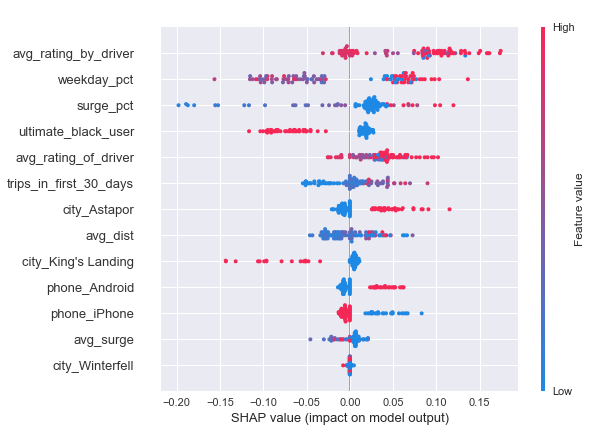

In [158]:
shap.summary_plot(shap_values[0], X_test.iloc[0:99])

The summary plot above shows SHAP values and relative feature values for each individual among the 100 examined here. Any point to the right of the plot corresponds to a prediction of "False" for each feature, and vice versa for those on the left side. Values colored red refer to high values for the feature in question, and vice versa for blue. Due to the massive size of the dataset (for my computer's purposes), the allocation of values here is based on a training set that was derived through K-weighted means, so this could be a source of error. Since this is a very small subset of the overall dataset, it is expected that bias may be present here. Some patterns in the summary plot may be different with the full dataset. One thing that immediately appears odd is that the average rating by driver is ranked highest, with values showing the greatest range of effects on SHAP value, but practically all values for that feature correspond to a "False" prediction. This would suggest more sampling is needed to fully develop this analysis, and a similar pattern appears also with average ratings of drivers. Moving on from thesee, weekday percentage shows a mix of results, though medium values correspond to a prediction of "True" for rider longevity. It could be that rarely using the service on the weekday corresponds to riders preferring another way to get to work, while relying upon the service during the weekdays compels a user to find another way (perhaps is too expensive for very long). Being an Ultimate Black user corresponds to rider longevity, and fewer trips in the first 30 days does as well. Signing up in Astapor corresponds to not sticking with the service into the sixth month, while King's Landing has the opposite effect, and Winterfell does not matter as much. Average distance shows a complex pattern. Android use corresponds to not sticking with the service, while iPhone use has the opposite relationship. Average surge shows a slight pattern in which a low value here corresponds to not sticking with the service, while medium to high values correspond to longevity with the service. It is a weak signal either way for that feature, though. 

## Conclusion

For predicting which users will show longevity with the riding service into the sixth month using this dataset, multiple machine learning models give similar results, but the gradient boosting classifier, applied to the basic dataset (not over-, under-, or resampled) and with mode imputation for missing data, seemed to perform the best for the most metrics, with the tuned model giving an accuracy of 0.81, and AUC-ROC of 0.8187, an F1 score of 0.79, and relatively decent precision and recall for the minority class compared to other models. 

One thing that was not addressed above was outliers. Overall among histograms, even though some x-axes have long scales, there does not appear to be a large amount of obvious outliers. For some variables that have obvious points out of the norm, these plausibly reflect realistic data. It could be useful to remove some possible outliers to enhance model accuracy metrics, but for a first pass I am not inclined to remove data that appear likely real.

The SHAP python package enables interpretability of the model passed into it, and though the analyses shown here reflect just a small snapshot of data, this technique can be illuminating for figuring out what matters on an individual basis and a way to judge predictions.